In [180]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

데이터 로드 (q: 15분 단위, h: 1시간 단위)

In [181]:
generation_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_generation.csv")
generation_q['Time'] = pd.to_datetime(generation_q['Time'], format='%Y-%m-%d %H:%M')

In [182]:
generation_q['Hour'] = generation_q['Time'].dt.floor('H')    # 시간으로 그룹화
generation_h = generation_q.groupby('Hour').sum(numeric_only=True)  # 각 시간대별로 합계 계산

In [183]:
demand_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_demand.csv")
demand_q['Time'] = pd.to_datetime(demand_q['Time'], format='%Y-%m-%d %H:%M')

In [184]:
demand_q['Hour'] = demand_q['Time'].dt.floor('H')    # 시간으로 그룹화
demand_h = demand_q.groupby('Hour').sum(numeric_only=True)  # 각 시간대별로 합계 계산

In [185]:
price_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_price.csv")
price_q['Time'] = pd.to_datetime(price_q['Time'], format='%Y-%m-%d %H:%M')

set 설정

In [186]:
I = list(range(len(generation_q.columns) - 2))
T = list(generation_q['Time'].dt.hour.unique())

In [187]:
S = list(range(20))
prob = {s: 1 / len(S) for s in S}

Generation (randomized) 

In [188]:
# random=2

In [189]:
generation_avg = {
    (i, t): generation_h[generation_h.index.hour == t].mean()[i] for i in I for t in T
}   

In [190]:
# # Low randomness
# np.random.seed(7)
# noise_factors = {(i, t, s): np.random.uniform(0.8, 1.2) for i in I for t in T for s in S}
# generation_r = {
#     (i, t, s): generation_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
# }

# # medium randomness
# np.random.seed(7)
# noise_factors = {(i, t, s): np.random.uniform(0.5, 1.5) for i in I for t in T for s in S}
# generation_r = {
#     (i, t, s): generation_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
# }

# high randomness   
np.random.seed(7)
noise_factors = {(i, t, s): np.random.uniform(0.2, 1.8) for i in I for t in T for s in S}
generation_r = {
    (i, t, s): generation_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
}

# print(noise_factors)

Demand (randomized)

In [191]:
demand_avg = {
    (i, t): demand_h[demand_h.index.hour == t].mean()[i] for i in I for t in T
}

In [192]:
# # low randomness
# np.random.seed(17)
# noise_factors = {(i, t, s): np.random.uniform(0.8, 1.2) for i in I for t in T for s in S}
# demand_r = {
#     (i, t, s): demand_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
# }

# # medium randomness
# np.random.seed(17)
# noise_factors = {(i, t, s): np.random.uniform(0.5, 1.5) for i in I for t in T for s in S}
# demand_r = {
#     (i, t, s): demand_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
# }

# high randomness
np.random.seed(17)
noise_factors = {(i, t, s): np.random.uniform(0.2, 1.8) for i in I for t in T for s in S}
demand_r = {
    (i, t, s): demand_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
}

# print(noise_factors)

Residual = generation - demand

In [193]:
residual = {(i, t, s): generation_r[(i, t, s)] - demand_r[(i, t, s)] for i in I for t in T for s in S}

In [194]:
residual

{(0, 0, 0): -3.2315396459909778,
 (0, 0, 1): -5.0481207705117415,
 (0, 0, 2): -2.4372418119620614,
 (0, 0, 3): -1.4852808139113653,
 (0, 0, 4): -7.0224529776952735,
 (0, 0, 5): -6.016449155370424,
 (0, 0, 6): -5.871590598909987,
 (0, 0, 7): -5.394860776414677,
 (0, 0, 8): -1.263286599477254,
 (0, 0, 9): -3.717746292958431,
 (0, 0, 10): -8.244523437092306,
 (0, 0, 11): -1.424778001764628,
 (0, 0, 12): -7.615900497314118,
 (0, 0, 13): -7.7179624721893525,
 (0, 0, 14): -1.3566948532612644,
 (0, 0, 15): -5.9862506197439584,
 (0, 0, 16): -5.211175698188673,
 (0, 0, 17): -5.5635245998625775,
 (0, 0, 18): -4.685735261185645,
 (0, 0, 19): -3.141631115138414,
 (0, 1, 0): -3.077628937141005,
 (0, 1, 1): -4.998129338432472,
 (0, 1, 2): -3.7936784604359812,
 (0, 1, 3): -6.652514779740824,
 (0, 1, 4): -3.956762937091542,
 (0, 1, 5): -1.957823275809618,
 (0, 1, 6): -2.008649203377326,
 (0, 1, 7): -1.312000734514094,
 (0, 1, 8): -6.137952748494016,
 (0, 1, 9): -3.038305054249177,
 (0, 1, 10): -2.3573

In [195]:
R = {
    (i, t, s): max(0, residual[(i, t, s)])
    for i in I for t in T for s in S
}

In [196]:
R[0,12,9]

5.983354887076461

In [197]:
R_avg = {
    s: {(i, t): sum(R[(i, t, s)] for i in I for t in T) / (len(I) * len(T)) for i in I for t in T} for s in S
}
import pandas as pd

R_avg_df = pd.DataFrame(R_avg)
R_avg_df.to_csv('R_avg.csv', index=False)


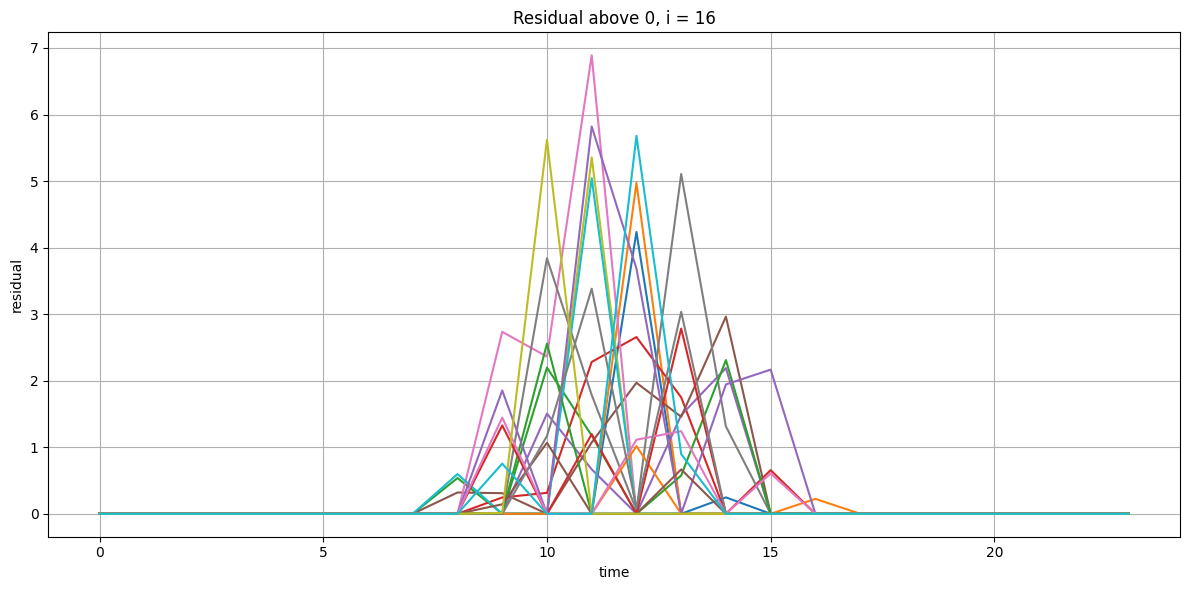

In [198]:
plt.figure(figsize=(12, 6))

for i in I[16:17]:
    for s in S:
        plt.plot([t for t in T], [R[i, t, s] for t in T])

plt.title(f'Residual above 0, i = {i}')
plt.xlabel('time')
plt.ylabel('residual')
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()

Price 설정

In [199]:
unique_days = generation_q['Time'].dt.normalize().unique()
days = len(unique_days)
D = list(range(min(len(S), days)))

In [200]:
price_q['Hour'] = price_q['Time'].dt.floor('H')    # 시간으로 그룹화
price_h = price_q.groupby('Hour').mean(numeric_only=True)  # 각 시간대별로 평균 계산

price = price_h.iloc[:len(D)*len(T)]

In [201]:
price

,Price
Hour,
2018-01-01 00:00:00,29.3600
2018-01-01 01:00:00,27.5250
2018-01-01 02:00:00,27.2375
2018-01-01 03:00:00,24.8750
2018-01-01 04:00:00,23.2650
...,...
2018-01-20 19:00:00,18.6175
2018-01-20 20:00:00,18.1225
2018-01-20 21:00:00,17.3250


In [202]:
# 전일 시장 가격 (Day-ahead) 및 실시간 시장 가격 (Real-time)
P_DA = {t: sum(price['Price'].iloc[t + d * len(T)] for d in D) / len(D) * 1.2 for t in T}
P_RT = {(t, d): price['Price'].iloc[t + d * len(T)] for t in T for d in D}

# 패널티 비용 계산
P_PN = {t: sum(price['Price'].iloc[t + d * len(T)] for d in D) / len(D) * 2 for t in T}

In [203]:
# P_DA
# P_RT
# P_PN

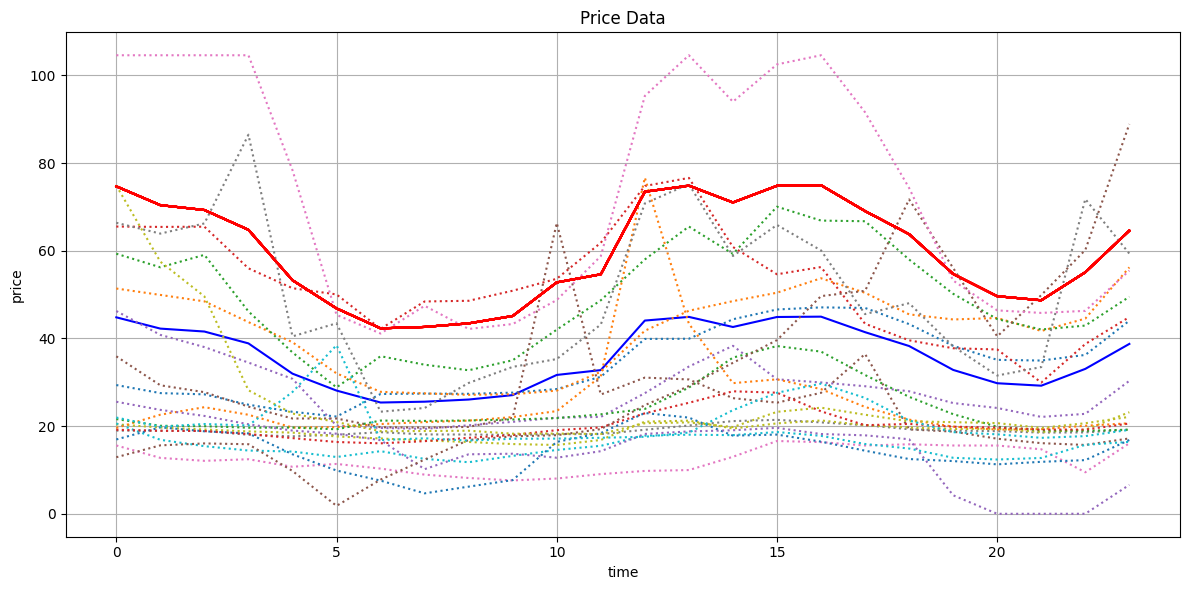

In [204]:
plt.figure(figsize=(12, 6))
plt.plot([t for t in T], [P_DA[t] for t in T], 'b-', label='DA price')

for d in D:
    plt.plot([t for t in T], [P_RT[t, d] for t in T], ':', label=f'RT price (d={d})')
    plt.plot([t for t in T], [P_PN[t] for t in T], 'r-', label=f'Penalty price (d={d})')

plt.title('Price Data')
plt.xlabel('time')
plt.ylabel('price')
plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()

모델 DER with Aggregation (Part: Aggregation)

In [205]:
alpha_DA = {t: cp.Variable(pos=True) for t in T}
beta_plus = {(t, s): cp.Variable(pos=True) for t in T for s in S}
beta_minus = {(t, s): cp.Variable(pos=True) for t in T for s in S}

In [206]:
obj_case2 = sum(
    P_DA[t] * alpha_DA[t] for t in T
) + sum(
    prob[s] * (P_RT[t, s] * beta_plus[t, s] - P_PN[t] * beta_minus[t, s])
    for t in T for s in S
)

In [207]:
# 제약조건
constraints_case2 = []

for t in T:
    for s in S:
        constraints_case2.append(sum(R[i, t, s] for i in I) - alpha_DA[t] == beta_plus[t, s] - beta_minus[t, s])

In [208]:
for t in T:
    for s in S:
        constraints_case2.append(sum(R[i,t,s] for i in I) >= beta_plus[t, s])

In [209]:
# y+와 y-의 동시 발생 방지
M = max(sum(R[i,t,s] for i in I) for t in T for s in S)
z_case2 = {(t, s): cp.Variable(boolean=True) for t in T for s in S}
for t in T:
    for s in S:
            constraints_case2.append(beta_plus[t, s] <= M * z_case2[t, s])
            constraints_case2.append(beta_minus[t, s] <= M * (1 - z_case2[t, s]))

In [210]:
prob_case2 = cp.Problem(cp.Maximize(obj_case2), constraints_case2)

# 풀이 실행 및 최적해 간격 설정
prob_case2.solve(solver='GUROBI', TimeLimit=60*30, IntFeasTol=1e-9)

19557.267298949704

In [211]:
# 결과 출력
print("Case 2 최적해:")
print(f"총 이익: {prob_case2.value}")

Case 2 최적해:
총 이익: 19557.267298949704


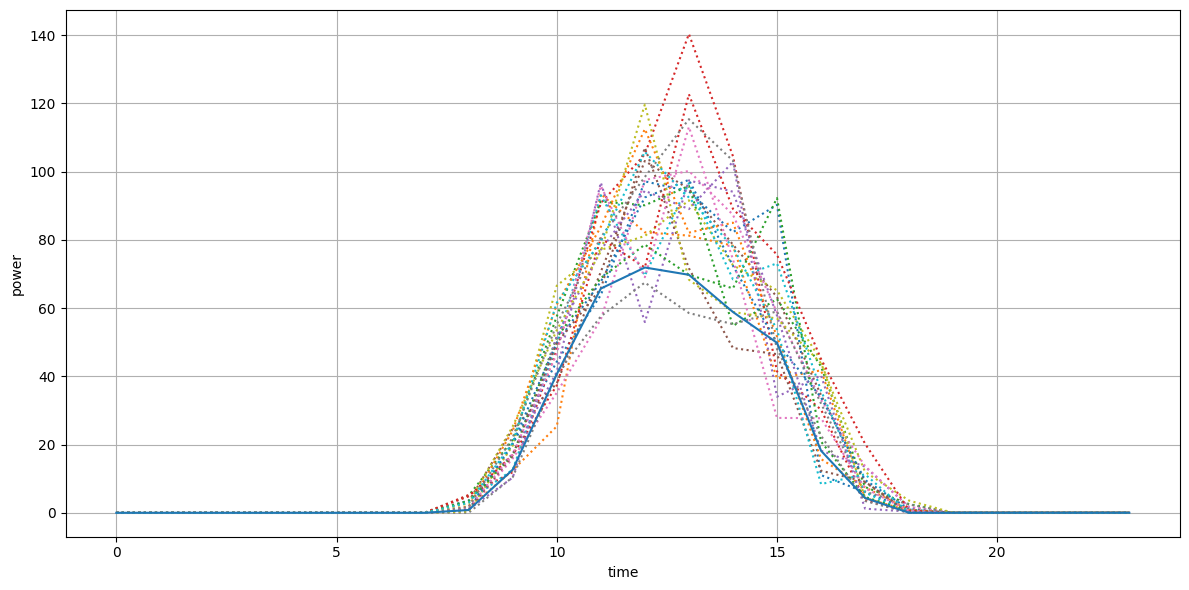

In [212]:
plt.figure(figsize=(12, 6))

for s in S:
    plt.plot([t for t in T], [sum(R[i,t,s] for i in I) for t in T], ':', label=f'Residual {s}')
plt.plot([t for t in T], [alpha_DA[t].value for t in T], '-', label='aggregated commitment')
    # plt.plot([t for t in T], [y_plus_1[i,t,s].value for t in T], 'b:', label='Case 1 y+')

plt.xlabel('time')
plt.ylabel('power')
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [213]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for t in T:
    total_da_profit_obj += P_DA[t] * alpha_DA[t].value

# Real-time 수익 비교
total_rt_profit_obj = 0
for t in T:
    for s in S:
        rt_profit_obj = P_RT[t, s] * beta_plus[t, s].value
        total_rt_profit_obj += prob[s] * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for t in T:
    for s in S:
        penalty_cost_obj = P_PN[t] * beta_minus[t, s].value
        total_penalty_cost_obj += prob[s] * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj

# 결과 출력
print(f"총 Day-ahead 수익 (_obj): {total_da_profit_obj:.2f}")
print(f"총 Real-time 수익 (_obj): {total_rt_profit_obj:.2f}")
print(f"총 Penalty 비용 (_obj): {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

총 Day-ahead 수익 (_obj): 15845.45
총 Real-time 수익 (_obj): 4397.54
총 Penalty 비용 (_obj): 685.72
목적 함수 기반 총 이익 (_obj): 19557.27


In [214]:
print("Case 2 최적해:")
print(f"총 이익: {prob_case2.value}")

Case 2 최적해:
총 이익: 19557.267298949704


In [215]:
alpha_DA_df = pd.DataFrame({'alpha_DA': [alpha_DA[t].value for t in T]})
alpha_DA_df.to_csv('result_alpha_DA.csv', index=False)

In [216]:
for t in T:
    for s in S:
        if beta_plus[t, s].value > 0.000001 and beta_minus[t, s].value > 0.000001:
            print(f"시간 {t}, 시나리오 {s}: beta+와 beta-가 동시에 발생했습니다.")
            break
else:
    print(f"beta+와 beta-가 동시에 발생하지 않았습니다.")

beta+와 beta-가 동시에 발생하지 않았습니다.


In [217]:
# for s in S:
#     print(f"beta_plus[17,{s}]: {beta_plus[17,s].value}")
#     print(f"beta_minus[17,{s}]: {beta_minus[17,s].value}")


In [218]:
# 각 t에 대한 alpha, beta +,-의 시나리오 평균 계산
for t in T:
    avg_alpha = alpha_DA[t].value
    avg_beta_plus = sum(beta_plus[t, s].value for s in S) / len(S)
    avg_beta_minus = sum(beta_minus[t, s].value for s in S) / len(S)
    print(f"시간 {t}: alpha: {avg_alpha:.2f}, beta+: {avg_beta_plus:.2f}, beta-: {avg_beta_minus:.2f}")

print(sum(alpha_DA[t].value for t in T))

시간 0: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 1: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 2: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 3: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 4: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 5: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 6: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 7: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 8: alpha: 0.82, beta+: 1.54, beta-: 0.07
시간 9: alpha: 12.62, beta+: 5.49, beta-: 0.27
시간 10: alpha: 40.64, beta+: 8.92, beta-: 1.34
시간 11: alpha: 65.71, beta+: 13.61, beta-: 0.95
시간 12: alpha: 71.89, beta+: 19.34, beta-: 1.28
시간 13: alpha: 69.76, beta+: 24.52, beta-: 0.63
시간 14: alpha: 58.86, beta+: 19.75, beta-: 0.91
시간 15: alpha: 49.82, beta+: 10.63, beta-: 3.09
시간 16: alpha: 18.20, beta+: 12.81, beta-: 1.26
시간 17: alpha: 4.34, beta+: 3.92, beta-: 0.23
시간 18: alpha: 0.00, beta+: 0.90, beta-: 0.00
시간 19: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 20: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 21: alpha: 0.00, beta+: 0.00, beta-: 0.00
시간 22:

In [219]:
agg_value = pd.DataFrame({'agg_value': [prob_case2.value]})
agg_value.to_csv('result_agg_value.csv', index=False)